# Titanic

The dataset is from a competition in kaggle at https://www.kaggle.com/c/titanic.

The goal is to predict which passengers suvived in the Titanic sjipwreck.

A part of code in this project refers to some codes in the competition.

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import csv
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [5]:
# set a random seed for reporducibility
myseed = 666
np.random.seed(myseed)
torch.manual_seed(myseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [6]:
# path to the training/test data
train_path = 'data/train.csv'
test_path = 'data/test.csv'

# read the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
original_df_train = df_train
original_df_test = df_test

In [29]:
print('Survival rate= ',df_train[df_train['Survived'] == 1].count()['Survived'] / len(df_train))
print('Death rate= ',df_train[df_train['Survived'] == 0].count()['Survived'] / len(df_train))


Survival rate=  0.3838383838383838
Death rate=  0.6161616161616161


In [476]:
display(df_train.head())
print('-' * 40)
display(df_test.head())


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


----------------------------------------


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [477]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [478]:
print('Trained data missing values:\n')
print(df_train.isnull().sum())
print('\n','-'*40, '\n')
print('Test data missing values:\n')
print(df_test.isnull().sum())

Trained data missing values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

 ---------------------------------------- 

Test data missing values:

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [479]:
df_train = df_train.drop(['Cabin'], axis=1)
df_test = df_test.drop(['Cabin'], axis=1)

# Check the current datasets

print('Train dataframe information:')
display(df_train.describe(include=['O']))
display(df_train.describe())
print('---'*30)
print('Test dataframe information:')
display(df_test.describe(include=['O']))
display(df_test.describe())

Train dataframe information:


,Name,Sex,Ticket,Embarked
count,891,891,891,889
unique,891,2,681,3
top,"Braund, Mr. Owen Harris",male,347082,S
freq,1,577,7,644


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


------------------------------------------------------------------------------------------
Test dataframe information:


,Name,Sex,Ticket,Embarked
count,418,418,418,418
unique,418,2,363,3
top,"Kelly, Mr. James",male,PC 17608,S
freq,1,266,5,270


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Here I am doing exploratory data analysis including visualisation etc.

There are numerical, categorical, and text data in the data sumarised as below
1. numerical data: Age, Fare, SibSp, Parch
2. categorical data: Survived (target), Sex, Pclass, Embarked
3. text data: Name, Ticket


In [480]:
import seaborn as sns

In [481]:
df_train['Age']

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

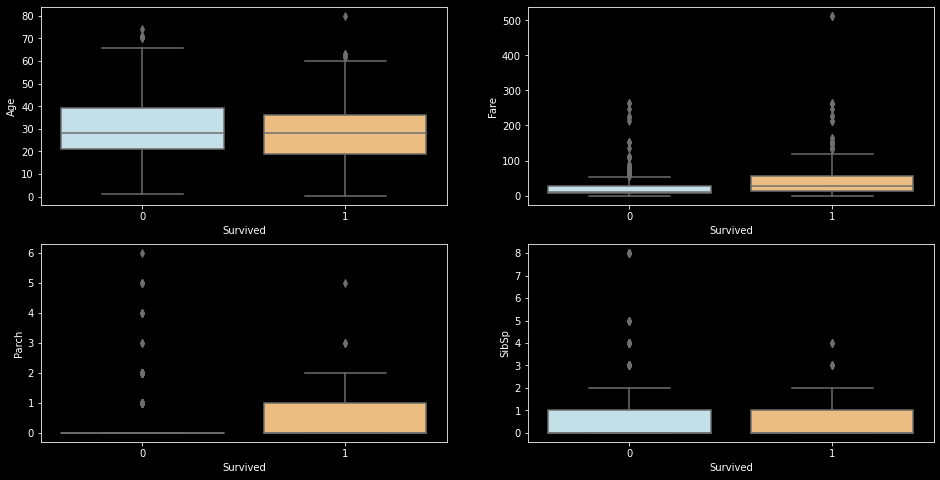

In [482]:
# now visualise the numerical data
num_list = ["Age", "Fare", "Parch", "SibSp"]

fig = plt.figure(figsize = (16,8))
# plt.subplots_adjust(top=1.25, bottom=1.2)

# use boxplot to plot numerical value against categorical value
for i, feature in enumerate(num_list):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data = df_train, x = "Survived", y = feature, palette = "RdYlBu_r" )
    # column = num_list[i]
    # sub = fig.add_subplot(2, 2, i + 1)
    # chart = sns.boxplot(data = df_train, x = "Survived", y = column, palette = "RdYlBu_r" )

### Information from the above figure
* The figure shows that overall the group of younger people has higher propability to survive. The more detail such as survival rate to various age ranges will be discussed later. 
* The feature fare indeed affects the survival probability. Or say large amount of survived people travel with high fare.
* Roughly speaking, in comparison to the survived people, all people passed away in the incident have zero parents or children aboard the Titanic.
* For SibSp, there is no distinct connection between survival rate and number of siblings/spouses aboard the Titanic

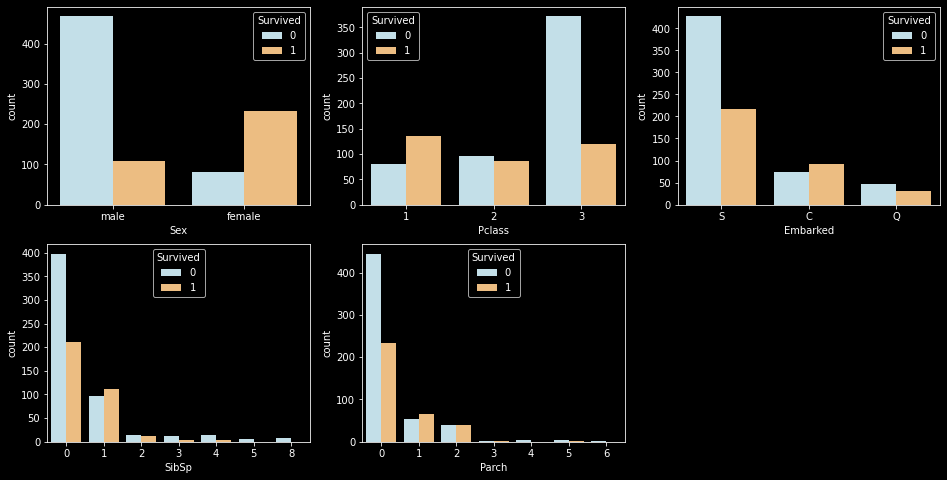

In [483]:
# visualise the categorical data vs survival rate

cat_list = ["Sex", "Pclass", "Embarked", "SibSp", "Parch"]

fig = plt.figure(figsize = (16,8))

for i, feature in enumerate(cat_list):
    plt.subplot(2, 3, i + 1)
    sns.countplot(data = df_train, x = feature, hue = "Survived", palette = "RdYlBu_r")
    

### Information from the above figure
* For sex data, it shows that female survives with higher probability comparing to male.
* There are 3 classes of tickets denoted as 1, 2, and 3. The figure shows majority of people who bought Class 3 did not survive. The number of survival and death in Class 2 is half-half. Number of suirvival is larger for Class 1, which is significantly distinc from Class 2 and 3.
* There is no clear clue that concludes differences between the places of embarkation. But for embarkation S, the number of death is higher.
* Fo sibSp, mose of people who died did not have siblings aboard the Titanic, and it is similar for Parch case. The connection between survival rate and SibSp/Parch is not clear for SibSp/Parch is 1 or larger. These features might be processed futher. 

# Visualisation for age data

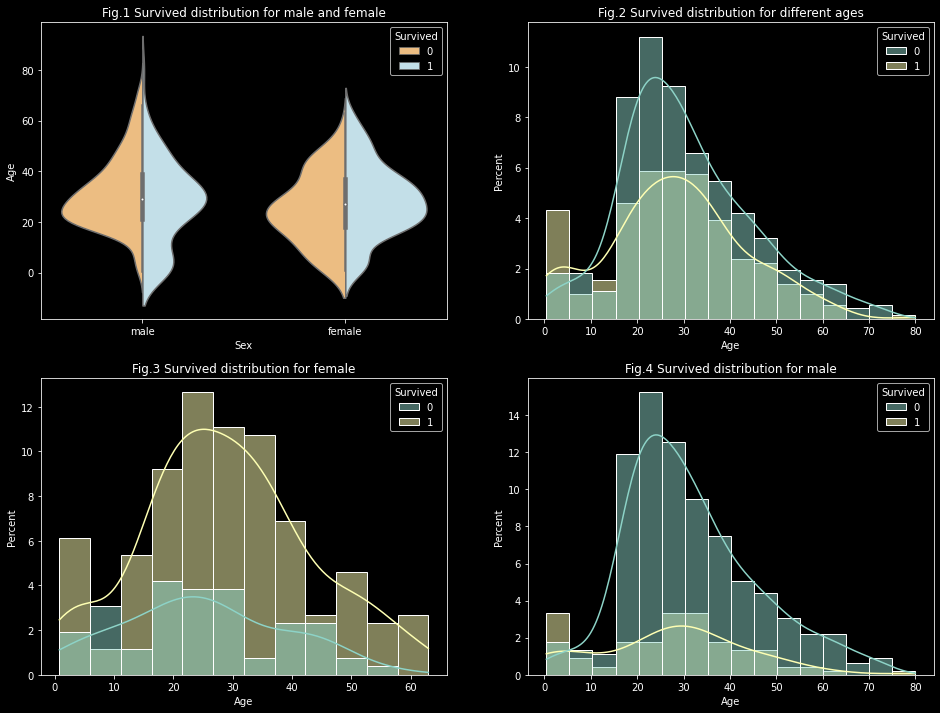

In [484]:
fig = plt.figure(figsize = (16,12))

# chart 1: survived distribution for male and female

sub = fig.add_subplot(2,2,1)
chart = sns.violinplot(data=df_train, x="Sex", y="Age", 
                       hue="Survived", palette = "RdYlBu",
                       split=True).set(title='Fig.1 Survived distribution for male and female')

# chart 2: survived distribution for all ages

sub = fig.add_subplot(2,2,2)
chart = sns.histplot(data=df_train, x="Age", 
                     hue="Survived",kde=True, 
                     bins=16,stat='percent').set(title='Fig.2 Survived distribution for different ages')

# chart 3: survived distribution for female

sub = fig.add_subplot(2,2,3)
chart = sns.histplot(data=df_train[df_train["Sex"]=="female"], 
                     x="Age", hue="Survived",
                     kde=True, bins=12,
                     stat='percent').set(title='Fig.3 Survived distribution for female')

# chart 4: survived distribution for male

sub = fig.add_subplot(2,2,4)
chart = sns.histplot(data=df_train[df_train["Sex"]=="male"], x="Age", 
                     hue="Survived",kde=True, 
                     bins=16, stat='percent').set(title='Fig.4 Survived distribution for male')
plt.show()


# Information from the above figure
* Fig. 1 shows for both male and female highest survival number occurs around 30 of age. The larger number of death happens around 20-25 age.
* In contrast to male, the number of survival and death are equal among female.

* Fig. 2 shows the overall number of survival and death. It shows the age 0-10 has largest survival rate, while adult has less survival rate.

* Fig. 3 shows for female the number of survival is higher than that of death.

* Fig. 4 shows for male the number of survival is lower than that of death.

## Analyse and process text data (Name and Ticket)

### Process Name
* For name, we are able to recognise their sex (Mr or Miss), marriage statement (Miss or Mrs), social position and job (Doctor, Master, etc.), which might be related to the sruvival rate.
* The ticket number does not show clear connection to survived or other features, thus feature ticket is discarded.

In [485]:
display(df_train[['Name', 'Ticket']].head())
display(df_test[['Name', 'Ticket']].head())

,Name,Ticket
0,"Braund, Mr. Owen Harris",A/5 21171
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",PC 17599
2,"Heikkinen, Miss. Laina",STON/O2. 3101282
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",113803
4,"Allen, Mr. William Henry",373450


,Name,Ticket
0,"Kelly, Mr. James",330911
1,"Wilkes, Mrs. James (Ellen Needs)",363272
2,"Myles, Mr. Thomas Francis",240276
3,"Wirz, Mr. Albert",315154
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",3101298


In [486]:
df_train['Title'] = df_train['Name'].str.extract(r'([A-Za-z]+)\.')
df_test['Title'] = df_test['Name'].str.extract(r'([A-Za-z]+)\.')

display(df_train.Title.value_counts())
display('-' * 40)

display(df_test.Title.value_counts())

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Countess      1
Capt          1
Ms            1
Sir           1
Lady          1
Mme           1
Don           1
Jonkheer      1
Name: Title, dtype: int64

'----------------------------------------'

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: Title, dtype: int64

In [487]:
# clean the data, fix some typos and classify name as 'other'
data = [df_train, df_test]

for df in data:
    df['Title'] = df['Title'].replace(['Countess', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Other')
    df['Title'] = df['Title'].replace(['Mlle','Ms'], 'Miss')
    df['Title'] = df['Title'].replace(['Capt','Sir'], 'Mr')
    df['Title'] = df['Title'].replace(['Lady','Mme'], 'Mrs')

In [488]:
print('Titles in train dataframe:')
display(df_train['Title'].value_counts()) 
print('---'*30)

print('Titles in test dataframe:')
display(df_test['Title'].value_counts())
print('---'*30)

print('Survival rate for each title:')
display(df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

Titles in train dataframe:


Mr        519
Miss      185
Mrs       127
Master     40
Other      20
Name: Title, dtype: int64

------------------------------------------------------------------------------------------
Titles in test dataframe:


Mr        240
Miss       79
Mrs        72
Master     21
Other       6
Name: Title, dtype: int64

------------------------------------------------------------------------------------------
Survival rate for each title:


,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.157996
3,Mrs,0.795276
4,Other,0.300000


In [489]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S,Other
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C,Mr


# Correlation coefficient

In [490]:
# check the correlation coefficient of each feature.
# first convert the categorical symbols to corresponding numbers

cat_cols = ["Sex", "Embarked", "Title"]

# convert the data type 
corr_df_train = df_train.copy()
for cat in cat_cols:
    corr_df_train[cat] = corr_df_train.loc[:, cat].astype('category')

sex = corr_df_train['Sex'].cat.codes.values
emb = corr_df_train['Embarked'].cat.codes.values
tle = corr_df_train['Title'].cat.codes.values
sex = pd.DataFrame(sex)
emb = pd.DataFrame(emb)
tle = pd.DataFrame(tle)
cat_feature = pd.concat([sex, emb, tle], axis=1)
cat_feature.columns = ['Sex','Embarked','Title']

corr_df_train.drop(['Sex', 'Embarked','Title'], inplace=True, axis=1)

corr_df_train = pd.concat([corr_df_train, cat_feature], axis=1)


In [491]:
# another method to convert catergorical symbols to numerical values
# df_train['Sex'] = df_train['Sex'].map( {'female': 1, 'male': 0, 'Nan': 'Nan'} ).astype(int)
# df_train['Embarked'] = df_train['Embarked'].map( {'C': 0, 'Q': 1, 'S':2} ).astype(int)

In [492]:
corr_df_train

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,2,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,1,2,4
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,0,2,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,0,2,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,1,0,2


<AxesSubplot:>

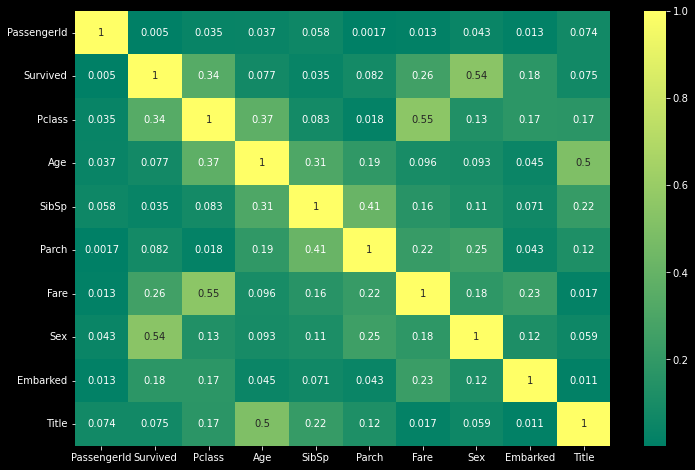

In [493]:
fig_dim = (12, 8)
fig, ax = plt.subplots(figsize=fig_dim)
sns.heatmap(abs(corr_df_train.corr()), annot=True, cmap='summer')

In [494]:
# extract the correlation to Survived
corr_df_train.corr()['Survived']

PassengerId   -0.005007
Survived       1.000000
Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Sex           -0.543351
Embarked      -0.176509
Title         -0.075164
Name: Survived, dtype: float64

### Information from the above correlation
* Survived is related to Sex, Pclass, Fare, and Embarked in descending order.
* Feature Pclass is strongly relevant to Fare.

# Deal with missing data

In [495]:
# first convert the categorical symbols to corresponding numbers

cat_cols = ["Sex", "Embarked", "Title"]

# convert the data type 
cop_df_test = df_test.copy()
for cat in cat_cols:
    cop_df_test[cat] = cop_df_test.loc[:, cat].astype('category')

sex = cop_df_test['Sex'].cat.codes.values
emb = cop_df_test['Embarked'].cat.codes.values
tle = cop_df_test['Title'].cat.codes.values
sex = pd.DataFrame(sex)
emb = pd.DataFrame(emb)
tle = pd.DataFrame(tle)
cat_feature = pd.concat([sex, emb, tle], axis=1)
cat_feature.columns = ['Sex','Embarked','Title']

cop_df_test.drop(['Sex', 'Embarked','Title'], inplace=True, axis=1)

cop_df_test = pd.concat([cop_df_test, cat_feature], axis=1)


In [496]:
# list missing values
print('Trained data missing values:\n')
print(df_train.isnull().sum())
print('\n','-'*40, '\n')
print('Test data missing values:\n')
print(df_test.isnull().sum())

Trained data missing values:

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Title            0
dtype: int64

 ---------------------------------------- 

Test data missing values:

PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Ticket          0
Fare            1
Embarked        0
Title           0
dtype: int64


### Fill missing value for 'Embarked' in training data

In [497]:
# use missing variables for Embarked missing data, so we keep corr_df_train as df_train
df_train = corr_df_train.copy()
df_test = cop_df_test.copy()
display(df_train)
display(df_test)

print('-' * 20 + 'After dropping Name and Ticket' + '-' * 20)
df_train.drop(['Name', 'Ticket'], axis=1, inplace=True) # drop the unnecessary features
df_test.drop(['Name', 'Ticket'], axis=1, inplace=True) # drop the unnecessary features
display(df_train)
display(df_test)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,1,2,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,0,2,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,0,2,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",27.0,0,0,211536,13.0000,1,2,4
887,888,1,1,"Graham, Miss. Margaret Edith",19.0,0,0,112053,30.0000,0,2,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,2,W./C. 6607,23.4500,0,2,1
889,890,1,1,"Behr, Mr. Karl Howell",26.0,0,0,111369,30.0000,1,0,2


,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Sex,Embarked,Title
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,1,1,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,0,2,3
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,1,1,2
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,1,2,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,1,2,2
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,0,0,4
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,1,2,2
416,1308,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,1,2,2


--------------------After dropping Name and Ticket--------------------


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Title
0,1,0,3,22.0,1,0,7.2500,1,2,2
1,2,1,1,38.0,1,0,71.2833,0,0,3
2,3,1,3,26.0,0,0,7.9250,0,2,1
3,4,1,1,35.0,1,0,53.1000,0,2,3
4,5,0,3,35.0,0,0,8.0500,1,2,2
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.0,0,0,13.0000,1,2,4
887,888,1,1,19.0,0,0,30.0000,0,2,1
888,889,0,3,NaN,1,2,23.4500,0,2,1
889,890,1,1,26.0,0,0,30.0000,1,0,2


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Title
0,892,3,34.5,0,0,7.8292,1,1,2
1,893,3,47.0,1,0,7.0000,0,2,3
2,894,2,62.0,0,0,9.6875,1,1,2
3,895,3,27.0,0,0,8.6625,1,2,2
4,896,3,22.0,1,1,12.2875,0,2,3
...,...,...,...,...,...,...,...,...,...
413,1305,3,NaN,0,0,8.0500,1,2,2
414,1306,1,39.0,0,0,108.9000,0,0,4
415,1307,3,38.5,0,0,7.2500,1,2,2
416,1308,3,NaN,0,0,8.0500,1,2,2


### Fill missing values for 'Fare' in training and testing data

In [498]:
df_train['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [499]:
# check the correlation of age to other features
abs(corr_df_train.corr()['Fare']).sort_values(ascending=False)

Fare           1.000000
Pclass         0.549500
Survived       0.257307
Embarked       0.230365
Parch          0.216225
Sex            0.182333
SibSp          0.159651
Age            0.096067
Title          0.017318
PassengerId    0.012658
Name: Fare, dtype: float64

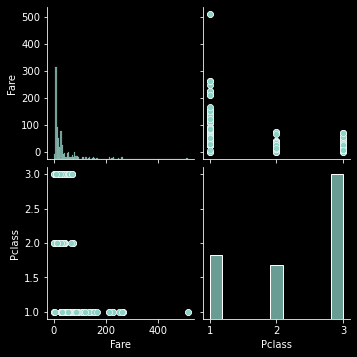

In [500]:
columns = ['Fare', 'Pclass']
sns.pairplot(df_train[columns])

In [501]:
# check the information of person whose fare data is missing
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Title
152,1044,3,60.5,0,0,NaN,1,2,2


In [502]:
display(df_train[(df_train['Pclass'] == 3) & (df_train['Embarked'] == 2) & (df_train['Parch'] == 0)].describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Title
count,270.000000,270.000000,270.0,220.000000,270.000000,270.0,270.000000,270.000000,270.0,270.000000
mean,451.259259,0.174074,3.0,28.165909,0.174074,0.0,10.195273,0.833333,2.0,1.929630
std,258.342744,0.379877,0.0,10.047421,0.467607,0.0,8.237354,0.373370,0.0,0.402884
min,1.000000,0.000000,3.0,5.000000,0.000000,0.0,0.000000,0.000000,2.0,1.000000
25%,221.500000,0.000000,3.0,21.000000,0.000000,0.0,7.775000,1.000000,2.0,2.000000
50%,458.500000,0.000000,3.0,26.000000,0.000000,0.0,7.925000,1.000000,2.0,2.000000
75%,668.750000,0.000000,3.0,32.000000,0.000000,0.0,8.662500,1.000000,2.0,2.000000
max,885.000000,1.000000,3.0,74.000000,3.000000,0.0,56.495800,1.000000,2.0,3.000000


In [503]:
# fill the missing value with mean
fare_mean = df_train[(df_train['Pclass'] == 3) & (df_train['Embarked'] == 2) & (df_train['Parch'] == 0) & (df_train['Sex'] == 1)]['Fare'].mean()
df_test['Fare'].fillna(fare_mean, inplace=True)
df_test.loc[[152]]

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Title
152,1044,3,60.5,0,0,10.156827,1,2,2


## Fill missing value for age in the training and testing data


In [504]:
df_train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [505]:
# check the correlation of age to other features
abs(corr_df_train.corr()['Age']).sort_values(ascending=False)

Age            1.000000
Title          0.498959
Pclass         0.369226
SibSp          0.308247
Parch          0.189119
Fare           0.096067
Sex            0.093254
Survived       0.077221
Embarked       0.044830
PassengerId    0.036847
Name: Age, dtype: float64

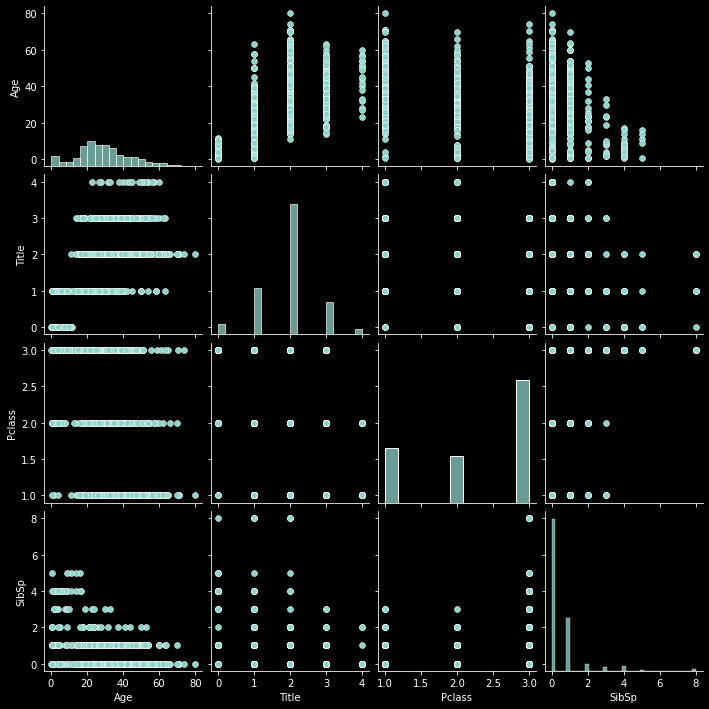

In [506]:
columns = ['Age','Title','Pclass','SibSp']
sns.pairplot(df_train[columns])

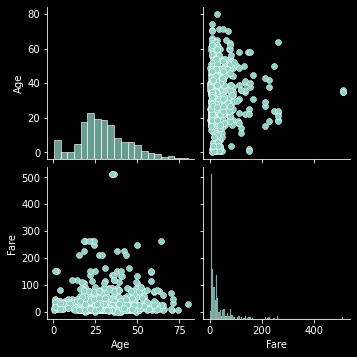

In [507]:
columns = ['Age','Fare']
sns.pairplot(df_train[columns])

In [508]:
df_train[df_train['Age'].isnull()].index

Int64Index([  5,  17,  19,  26,  28,  29,  31,  32,  36,  42,
            ...
            832, 837, 839, 846, 849, 859, 863, 868, 878, 888],
           dtype='int64', length=177)

In [509]:
# import different methods fro imputation 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [510]:
iter_imp = IterativeImputer(max_iter=10, random_state=0, initial_strategy='mean')

fitin_x = df_train.drop(['PassengerId', 'Survived'], axis=1)
fillin_age_train = iter_imp.fit_transform(fitin_x)
fillin_age_train = pd.DataFrame(fillin_age_train)

fitin_x = df_test.drop(['PassengerId'], axis=1)
fillin_age_test = iter_imp.transform(fitin_x)
fillin_age_test = pd.DataFrame(fillin_age_test)


In [511]:
df_test[df_test['Age'].isnull()].index

Int64Index([ 10,  22,  29,  33,  36,  39,  41,  47,  54,  58,  65,  76,  83,
             84,  85,  88,  91,  93, 102, 107, 108, 111, 116, 121, 124, 127,
            132, 133, 146, 148, 151, 160, 163, 168, 170, 173, 183, 188, 191,
            199, 200, 205, 211, 216, 219, 225, 227, 233, 243, 244, 249, 255,
            256, 265, 266, 267, 268, 271, 273, 274, 282, 286, 288, 289, 290,
            292, 297, 301, 304, 312, 332, 339, 342, 344, 357, 358, 365, 366,
            380, 382, 384, 408, 410, 413, 416, 417],
           dtype='int64')

In [512]:
final_df_train = pd.concat([df_train, fillin_age_train[1]], axis=1)
final_df_train.drop(['Age'], axis=1, inplace=True)
final_df_train.rename(columns={1: 'Age'}, inplace=True)

final_df_test = pd.concat([df_test, fillin_age_test[1]], axis=1)
final_df_test.drop(['Age'], axis=1, inplace=True)
final_df_test.rename(columns={1: 'Age'}, inplace=True)

In [513]:
display(final_df_train.head())
display(final_df_train.isnull().sum())
display(final_df_test.head())
display(final_df_test.isnull().sum())


,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,1,0,3,1,0,7.2500,1,2,2,22.0
1,2,1,1,1,0,71.2833,0,0,3,38.0
2,3,1,3,0,0,7.9250,0,2,1,26.0
3,4,1,1,1,0,53.1000,0,2,3,35.0
4,5,0,3,0,0,8.0500,1,2,2,35.0


PassengerId    0
Survived       0
Pclass         0
SibSp          0
Parch          0
Fare           0
Sex            0
Embarked       0
Title          0
Age            0
dtype: int64

,PassengerId,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,892,3,0,0,7.8292,1,1,2,34.5
1,893,3,1,0,7.0000,0,2,3,47.0
2,894,2,0,0,9.6875,1,1,2,62.0
3,895,3,0,0,8.6625,1,2,2,27.0
4,896,3,1,1,12.2875,0,2,3,22.0


PassengerId    0
Pclass         0
SibSp          0
Parch          0
Fare           0
Sex            0
Embarked       0
Title          0
Age            0
dtype: int64

# Drop useless data 

In [514]:
# This section is to drop useless data. The dummy variables are created here if necessary.
final_df_train.drop(['PassengerId'], axis=1, inplace=True)
final_df_test.drop(['PassengerId'], axis=1, inplace=True)

df_train = final_df_train
df_test = final_df_test

display(df_train)
display(df_test)


,Survived,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,0,3,1,0,7.2500,1,2,2,22.000000
1,1,1,1,0,71.2833,0,0,3,38.000000
2,1,3,0,0,7.9250,0,2,1,26.000000
3,1,1,1,0,53.1000,0,2,3,35.000000
4,0,3,0,0,8.0500,1,2,2,35.000000
...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,13.0000,1,2,4,27.000000
887,1,1,0,0,30.0000,0,2,1,19.000000
888,0,3,1,2,23.4500,0,2,1,14.976541
889,1,1,0,0,30.0000,1,0,2,26.000000


,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,3,0,0,7.8292,1,1,2,34.500000
1,3,1,0,7.0000,0,2,3,47.000000
2,2,0,0,9.6875,1,1,2,62.000000
3,3,0,0,8.6625,1,2,2,27.000000
4,3,1,1,12.2875,0,2,3,22.000000
...,...,...,...,...,...,...,...,...
413,3,0,0,8.0500,1,2,2,29.165907
414,1,0,0,108.9000,0,0,4,39.000000
415,3,0,0,7.2500,1,2,2,38.500000
416,3,0,0,8.0500,1,2,2,29.165907


# Modelling

In [515]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os

In [516]:
display(df_train, df_test)

,Survived,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,0,3,1,0,7.2500,1,2,2,22.000000
1,1,1,1,0,71.2833,0,0,3,38.000000
2,1,3,0,0,7.9250,0,2,1,26.000000
3,1,1,1,0,53.1000,0,2,3,35.000000
4,0,3,0,0,8.0500,1,2,2,35.000000
...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,13.0000,1,2,4,27.000000
887,1,1,0,0,30.0000,0,2,1,19.000000
888,0,3,1,2,23.4500,0,2,1,14.976541
889,1,1,0,0,30.0000,1,0,2,26.000000


,Pclass,SibSp,Parch,Fare,Sex,Embarked,Title,Age
0,3,0,0,7.8292,1,1,2,34.500000
1,3,1,0,7.0000,0,2,3,47.000000
2,2,0,0,9.6875,1,1,2,62.000000
3,3,0,0,8.6625,1,2,2,27.000000
4,3,1,1,12.2875,0,2,3,22.000000
...,...,...,...,...,...,...,...,...
413,3,0,0,8.0500,1,2,2,29.165907
414,1,0,0,108.9000,0,0,4,39.000000
415,3,0,0,7.2500,1,2,2,38.500000
416,3,0,0,8.0500,1,2,2,29.165907


In [517]:
train = df_train.drop(['Survived'],axis=1)
train_label = df_train['Survived']


In [518]:
train = train.astype(np.float)
train_label = train_label.astype(np.float)

train = torch.tensor(train.values, dtype=torch.float)
train_label = torch.tensor(train_label.values, dtype=torch.long)


In [519]:
display(train, test)
print(train.dtype)

tensor([[ 3.0000,  1.0000,  0.0000,  ...,  2.0000,  2.0000, 22.0000],
        [ 1.0000,  1.0000,  0.0000,  ...,  0.0000,  3.0000, 38.0000],
        [ 3.0000,  0.0000,  0.0000,  ...,  2.0000,  1.0000, 26.0000],
        ...,
        [ 3.0000,  1.0000,  2.0000,  ...,  2.0000,  1.0000, 14.9765],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  2.0000, 26.0000],
        [ 3.0000,  0.0000,  0.0000,  ...,  1.0000,  2.0000, 32.0000]])

tensor([[ 3.0000,  0.0000,  0.0000,  ...,  1.0000,  2.0000, 34.5000],
        [ 3.0000,  1.0000,  0.0000,  ...,  2.0000,  3.0000, 47.0000],
        [ 2.0000,  0.0000,  0.0000,  ...,  1.0000,  2.0000, 62.0000],
        ...,
        [ 3.0000,  0.0000,  0.0000,  ...,  2.0000,  2.0000, 38.5000],
        [ 3.0000,  0.0000,  0.0000,  ...,  2.0000,  2.0000, 29.1659],
        [ 3.0000,  1.0000,  1.0000,  ...,  0.0000,  0.0000, 10.6805]])

torch.float32


In [520]:
# create dataset in pytorch framework
class TitanicDataset(Dataset):
    def __init__(self, X, y=None):
        super().__init__()
        self.data = X
        if y is not None:
            self.label = torch.LongTensor(y)
        else:
            self.label = None
        
    def __getitem__(self, idx):
        if self.label is not None:
            return self.data[idx], self.label[idx]
        else:
            return self.data[idx]
    
    def __len__(self):
        return len(self.data)

In [521]:
train_x.dtype

torch.float32

In [522]:
# Split the training data into training set and validation set for preventing the overfitting.
# take 1/5 data from the original training set as validation set

val_ration = 0.2

percent = int(train.shape[0] * (1 - val_ration))
train_x, train_y, val_x, val_y = train[:percent], train_label[:percent], train[percent:], train_label[percent:]
print('Size of training set: {}'.format(train_x.shape))
print('Size of validation set: {}'.format(val_x.shape))

Size of training set: torch.Size([712, 8])
Size of validation set: torch.Size([179, 8])


In [523]:
train_set = TitanicDataset(train_x, train_label)
val_set = TitanicDataset(val_x, val_y)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [524]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(8, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, 2) 

        self.dropout = nn.Dropout(0.2)
        self.act_fn = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.act_fn(x)
        # X = self.dropout(x)

        x = self.layer2(x)
        x = self.act_fn(x)
        # X = self.dropout(x)

        x = self.layer3(x)
        x = self.act_fn(x)
        # X = self.dropout(x)

        x = self.out(x)
        
        return x

In [525]:
#check device
def get_device():
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [526]:
# fix random seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [527]:
# fix random seed for reproducibility
same_seeds(42)

device = get_device()
print(f'DEVICE: {device}')

# training parameters
n_epochs = 150               # number of training epoch
learning_rate = 0.0005       # learning rate

# the path where checkpoint saved
model_path = './deep_learinging_model_dropout0.ckpt'

model = Classifier().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

DEVICE: cpu


In [528]:
# start training

best_acc = 0.0
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    train_acc = 0.0
    train_loss = 0.0
    val_acc = 0.0
    val_loss = 0.0
    
    # training
    model.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        batch_loss = criterion(outputs, labels)
        _, train_pred = torch.max(outputs, 1)
        batch_loss.backward()
        optimizer.step()
        
        train_acc += (train_pred.cpu() == labels.cpu()).sum().item()
        train_loss += batch_loss.item()
    
    # validation 
    if len(val_set) > 0:
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(val_loader):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels) 
                _, val_pred = torch.max(outputs, 1) 
            
                val_acc += (val_pred.cpu() == labels.cpu()).sum().item()
                val_loss += batch_loss.item()

            print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f} | Val Acc: {:3.6f} loss: {:3.6f}'.format(
                epoch + 1, n_epochs, train_acc/len(train_set), train_loss/len(train_loader), val_acc/len(val_set), val_loss/len(val_loader)
            ))
            
            # if the model improves, save a checkpoint at this epoch
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), model_path)
                print('saving model with acc {:.3f}'.format(best_acc/len(val_set)))
    else:
        print('[{:03d}/{:03d}] Train Acc: {:3.6f} Loss: {:3.6f}'.format(
            epoch + 1, n_epochs, train_acc/len(train_set), train_loss/len(train_loader)
        ))
        
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

# if not validating, save the last epoch
if len(val_set) == 0:
    torch.save(model.state_dict(), model_path)
    print(f'saving model at the last epoch')

[001/150] Train Acc: 0.582865 Loss: 0.944492 | Val Acc: 0.642458 loss: 0.844827
saving model with acc 0.642
[002/150] Train Acc: 0.660112 Loss: 0.731312 | Val Acc: 0.642458 loss: 0.797571
[003/150] Train Acc: 0.622191 Loss: 0.713798 | Val Acc: 0.642458 loss: 0.667939
[004/150] Train Acc: 0.679775 Loss: 0.659148 | Val Acc: 0.642458 loss: 0.585734
[005/150] Train Acc: 0.660112 Loss: 0.670585 | Val Acc: 0.726257 loss: 0.555821
saving model with acc 0.726
[006/150] Train Acc: 0.672753 Loss: 0.618275 | Val Acc: 0.720670 loss: 0.529408
[007/150] Train Acc: 0.698034 Loss: 0.604586 | Val Acc: 0.670391 loss: 0.591124
[008/150] Train Acc: 0.653090 Loss: 0.694094 | Val Acc: 0.715084 loss: 0.517897
[009/150] Train Acc: 0.661517 Loss: 0.634729 | Val Acc: 0.698324 loss: 0.560900
[010/150] Train Acc: 0.685393 Loss: 0.598252 | Val Acc: 0.720670 loss: 0.523336
[011/150] Train Acc: 0.681180 Loss: 0.619018 | Val Acc: 0.720670 loss: 0.521230
[012/150] Train Acc: 0.683989 Loss: 0.587275 | Val Acc: 0.703911

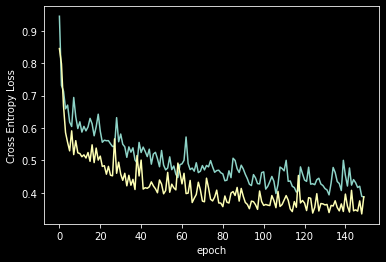

In [532]:
plt.plot(range(n_epochs), train_losses, val_losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [534]:
test = df_test
test = df_test.astype(np.float)
test = torch.tensor(test.values, dtype=torch.float)

test_set = TitanicDataset(test, None)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

model = Classifier().to(device)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [535]:
predict = []
model.eval() # set the model to evaluation mode
with torch.no_grad():
    for i, data in enumerate(test_loader):
        inputs = data
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs, 1) # get the index of the class with the highest probability

        for y in test_pred.cpu().numpy():
            predict.append(y)

In [537]:
print(predict)

[0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

In [546]:
with open('prediction_deep_learning_dropout0.csv', 'w') as f:
    f.write('Id,Class\n')
    for i, y in enumerate(predict):
        f.write('{},{}\n'.format(df_test['PassengerId'][i], y))
        
submission = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': predict})
submission.to_csv('submission.csv', index=False)

In [541]:
test_label_path = 'data/gender_submission.csv'

# read the test label
test_label = pd.read_csv(test_label_path)
test_label

In [545]:
print((test_label['Survived'].values == predict).sum() / len(test_label))

0.9521531100478469


The accuracy of this model is 0.95.